# Gaussian Mixture Model

### Load Package

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
# # this needs to be removed when the package is installed
import sys
sys.path.append('../')

import fredipy as fp

### Parameter

In [12]:
a1 = 1.0
a2 = 0.5

m1 = 1.0
m2 = 2.5

g1 = 0.05
g2 = 0.25

inverse_temperature = 50.

noise_amplitude = 1.0e-4

### Define Problem

In [13]:
def single_gaussian_peak(w, a, m, g):
    return a * np.exp(-((w - m) ** 2) / g)

def reference_spectral_func(w):
    return single_gaussian_peak(w, a1, m1, g1) + single_gaussian_peak(w, a2, m2, g2)

def kl_kernel(p, w):
    return w / (w**2 + p**2) / np.pi

def calc_Euclidean(p):
    return integrate.quad(lambda x: kl_kernel(p, x) * reference_spectral_func(x), 0., np.inf)[0]

### Numerical Discretization

In [14]:
freq_mesh = np.linspace(0, 5, 2001)
matsubara_mesh = np.array(np.arange(0, 100) * (2 * np.pi / inverse_temperature))

ref_spec = reference_spectral_func(freq_mesh)
ref_eucl = np.array([calc_Euclidean(w) for w in matsubara_mesh])

In [ ]:
noised_eucl = ref_eucl + noise_amplitude * np.random.randn(len(ref_eucl))

data = {
    'x': matsubara_mesh,
    'y': noised_eucl,
    'dy': noise_amplitude**2 }

### Visualize Beforehand

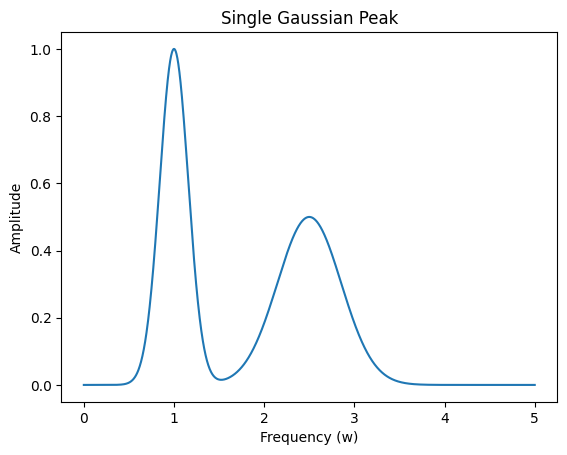

In [30]:
plt.plot(freq_mesh, ref_spec)
plt.xlabel("Frequency (w)")
plt.ylabel("Amplitude")
plt.title("Single Gaussian Peak")
plt.show()

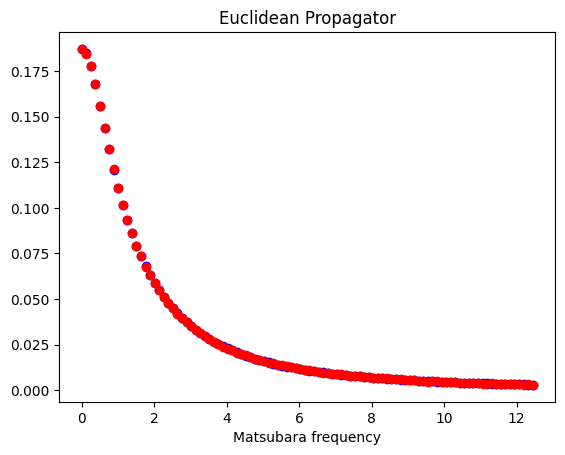

In [31]:
plt.scatter(matsubara_mesh, ref_eucl, color='blue', label='reference data')
plt.scatter(matsubara_mesh, noised_eucl, color='red', label='noisy data')
plt.xlabel("Matsubara frequency")
plt.title("Euclidean Propagator")
plt.show()

## Reconstruction

In [32]:
# use the RBF kernel
kernel = fp.kernels.RadialBasisFunction(0.5, 0.25)
# define the integrator method to use, with upper and lower bounds and number of points
integrator = fp.integrators.Riemann_1D(0, 15, 2000)

# ... and define the operator, the integration with the källen lehmann kernel
integral_op = fp.operators.Integral(kl_kernel, integrator)

# ... and define the full constraint using the date we genrated before
constraints = [fp.constraints.LinearEquality(integral_op, data)]

# now we can define the model using the contraints and the GP kernel
model = fp.models.GaussianProcess(kernel, constraints)

# ... and do a prediction
_rho, _rho_err = model.predict(freq_mesh)

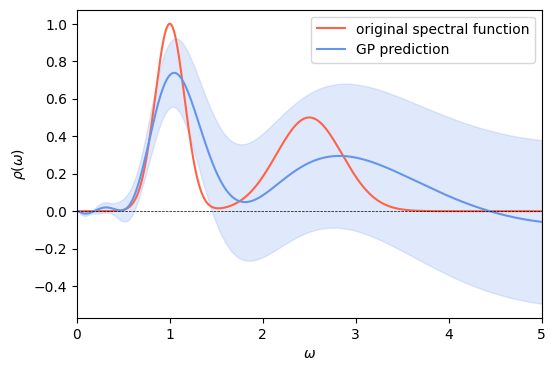

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(freq_mesh, ref_spec, color='tomato', label='original spectral function')
ax.plot(freq_mesh, _rho, color='cornflowerblue', label = 'GP prediction')
ax.fill_between(freq_mesh.squeeze(), _rho.squeeze() - _rho_err, _rho.squeeze() + _rho_err, color='cornflowerblue', alpha=0.2)

ax.set_xlim((min(freq_mesh), max(freq_mesh)))
ax.axhline(0, color='black', lw=0.5, ls='--')

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$\rho(\omega)$')

ax.legend();

### Euclidean Side

In [20]:
_G, _G_err = model.predict_data()

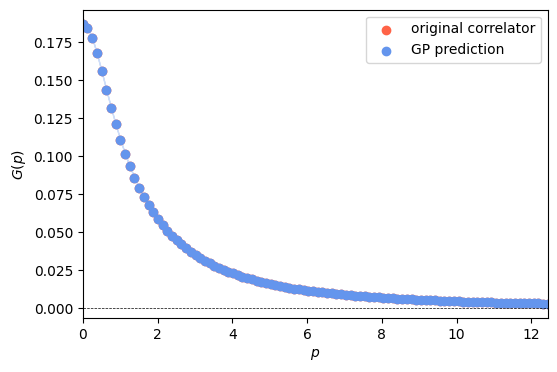

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(matsubara_mesh, ref_eucl, color='tomato', label='original correlator')
ax.scatter(matsubara_mesh, _G, color='cornflowerblue', label='GP prediction')
ax.fill_between(matsubara_mesh.squeeze(), _G.squeeze() - _G_err, _G.squeeze() + _G_err, color='cornflowerblue', alpha=0.3)

ax.set_xlim((0, max(matsubara_mesh)))
ax.axhline(0, color='black', lw=0.5, ls='--')

ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$G(p)$')

ax.legend();


## Include Asymptotics

In [22]:
def uv_asymptotics(w):
    return np.exp(-w**2)

### Reconstruction

In [27]:
# here, we now modifiy the kernel,
# first we define the RBF kernel as before
rbf = fp.kernels.RadialBasisFunction(0.5, 0.25)

# ... and then we define the asymptotic kernel
kernel = fp.kernels.AsymptoticKernel(rbf)

# ... add the known asymptotic form
kernel.add_asymptotics(region='UV', asymptotics=uv_asymptotics)
kernel.set_params([4.0, 1])

# here we just repeat some steps from before
integrator = fp.integrators.Riemann_1D(0.01, 15, 2000)
integral_op = fp.operators.Integral(kl_kernel, integrator)
constraints = [fp.constraints.LinearEquality(integral_op, data)] # deriviative of this kernel is not implemented yet

# now we can define the model using the contraints and the asymptotic GP kernel
model = fp.models.GaussianProcess(kernel, constraints)

# ... and do a prediction
_rho, _rho_err = model.predict(freq_mesh)

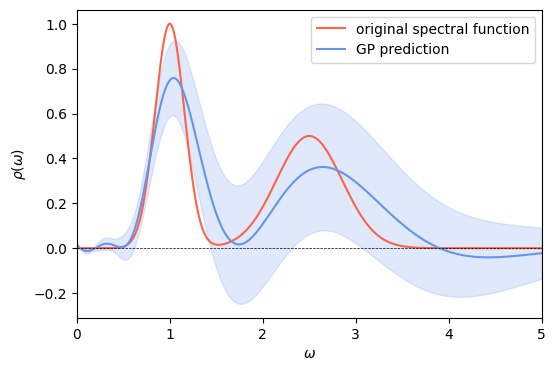

In [28]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(freq_mesh, ref_spec, color='tomato', label='original spectral function')
ax.plot(freq_mesh, _rho, color='cornflowerblue', label = 'GP prediction')
ax.fill_between(freq_mesh.squeeze(), _rho.squeeze() - _rho_err, _rho.squeeze() + _rho_err, color='cornflowerblue', alpha=0.2)

ax.set_xlim((min(freq_mesh), max(freq_mesh)))
ax.axhline(0, color='black', lw=0.5, ls='--')

ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$\rho(\omega)$')

ax.legend();